In [2]:
import random
import pandas as pd
import numpy as np
import redis
import json
from datetime import datetime, timedelta
import time
import uuid
import csv
import io
from tqdm import tqdm
from clickhouse_driver import Client
import matplotlib.pyplot as plt

In [3]:
from matplotlib import font_manager
font_path = 'SimHei.ttf'  # 替换为SimHei.ttf的实际路径
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'SimHei'

## 配置参数

In [4]:
# 配置参数
REDIS_HOST = "localhost"
REDIS_PORT = 6379
REDIS_PASSWORD = "quantide666"  # 添加Redis密码
REDIS_QUEUE_NAME = "test_queue"

CLICKHOUSE_HOST = "localhost"
CLICKHOUSE_PORT = 9000
CLICKHOUSE_DB = "test_data"
CLICKHOUSE_TABLE = "stock_data"

BATCH_SIZE = 100000  # 每批次处理的记录数
TOTAL_RECORDS = 100000000  # 总记录数 (1亿)

In [5]:
# 初始化Redis连接
redis_client = redis.StrictRedis(host=REDIS_HOST, port=REDIS_PORT, password=REDIS_PASSWORD, decode_responses=True)

# 测试连接
try:
    response = redis_client.ping()
    print(f"Redis连接成功: {response}")
except Exception as e:
    print(f"Redis连接失败: {str(e)}")

Redis连接成功: True


## generate stock data

In [6]:
# 生成股票和指数代码（沪市和深市各一半），返回symbols
def generate_symbols(num_stocks=5000):
    symbols = []
    
    for i in range(num_stocks):
        if i < num_stocks // 2:
            # 沪市股票 (600xxx, 601xxx, 603xxx, 605xxx, 688xxx)
            prefix = random.choice(['600', '601', '603', '605', '688'])
            suffix = str(random.randint(0, 999)).zfill(3)
            symbols.append(f"{prefix}{suffix}.SH")
        else:
            # 深市股票 (000xxx, 001xxx, 002xxx, 003xxx, 300xxx, 301xxx)
            prefix = random.choice(['000', '001', '002', '003', '300', '301'])
            suffix = str(random.randint(0, 999)).zfill(3)
            symbols.append(f"{prefix}{suffix}.SZ")
    
    # 添加主要指数
    indices = [
        # 上证指数
        "000001.SH",  # 上证综指
        "000016.SH",  # 上证50
        "000300.SH",  # 沪深300
        "000905.SH",  # 中证500
        "000852.SH",  # 中证1000
        # 深证指数
        "399001.SZ",  # 深证成指
        "399006.SZ",  # 创业板指
        "399300.SZ",  # 沪深300
        "399905.SZ",  # 中证500
        # 其他重要指数
        "000688.SH",  # 科创50
        "399673.SZ",  # 创业板50
    ]
    
    # 添加指数到符号列表
    symbols.extend(indices)
    
    return symbols

In [7]:
# 生成ST股票列表，返回st_stocks
def generate_st_stocks(symbols, st_ratio=0.05):
    """
    Args:
        symbols: 所有股票代码列表
        st_ratio: ST股票的比例
        
    Returns:
        ST股票代码集合
    """
    # 过滤掉指数
    stock_symbols = [s for s in symbols if not s in ["000001.SH", "000016.SH", "000300.SH", "000905.SH", 
                                                    "000852.SH", "399001.SZ", "399006.SZ", "399300.SZ", 
                                                    "399905.SZ", "000688.SH", "399673.SZ"]]
    
    # 随机选择一部分股票作为ST股票
    st_count = int(len(stock_symbols) * st_ratio)
    st_stocks = set(random.sample(stock_symbols, st_count))
    
    return st_stocks

In [9]:
# 生成一批股票数据
def generate_batch_data(batch_size, start_idx, symbols, trading_days, st_stocks):
    """
    Args:
        batch_size: 批次大小
        start_idx: 起始索引
        symbols: 股票和指数代码列表
        trading_days: 交易日列表
        st_stocks: ST股票代码集合
        
    Returns:
        包含股票数据的CSV字符串
    """
    # 准备CSV输出
    output = io.StringIO()
    csv_writer = csv.writer(output)
    
    # 生成数据
    for i in range(batch_size):
        if (start_idx + i) >= TOTAL_RECORDS:
            break
            
        # 随机选择股票/指数和日期
        symbol = random.choice(symbols)
        trade_date = random.choice(trading_days)
        
        # 判断是否为指数
        is_index = symbol in ["000001.SH", "000016.SH", "000300.SH", "000905.SH", "000852.SH", 
                             "399001.SZ", "399006.SZ", "399300.SZ", "399905.SZ", "000688.SH", "399673.SZ"]
        
        # 判断是否为ST股票
        is_st = symbol in st_stocks
        
        # 为指数生成不同范围的价格
        if is_index:
            if "000001.SH" in symbol:  # 上证综指
                base_price = random.uniform(2000, 6000)
            elif "399001.SZ" in symbol:  # 深证成指
                base_price = random.uniform(6000, 15000)
            elif "399006.SZ" in symbol:  # 创业板指
                base_price = random.uniform(1000, 3500)
            elif "000300.SH" in symbol or "399300.SZ" in symbol:  # 沪深300
                base_price = random.uniform(3000, 5500)
            else:  # 其他指数
                base_price = random.uniform(4000, 10000)
                
            # 指数波动通常较小
            high = base_price * random.uniform(1, 1.03)
            low = base_price * random.uniform(0.97, 1)
            open_price = random.uniform(low, high)
            close = random.uniform(low, high)
            
            # 指数成交量和金额较大
            vol = random.uniform(10000000, 100000000)
            amount = random.uniform(100000000, 1000000000)
            adjust = 1.0  # 指数没有复权因子
            
            # 指数没有ST状态和涨跌停限制
            st = False
            buy_limit = 0.0
            sell_limit = 0.0
        else:
            # 普通股票
            # ST股票价格通常较低
            if is_st:
                open_price = random.uniform(1, 10)
            else:
                open_price = random.uniform(5, 100)
                
            high = open_price * random.uniform(1, 1.1)
            low = open_price * random.uniform(0.9, 1)
            close = random.uniform(low, high)
            
            # 生成成交量和金额
            vol = random.uniform(10000, 10000000)
            amount = vol * close * random.uniform(0.9, 1.1)
            
            # 生成复权因子
            adjust = random.uniform(0.8, 1.2)
            
            # ST状态
            st = is_st
            
            # 涨跌停限制
            if is_st:
                # ST股票涨跌停限制为5%
                limit_pct = 0.05
            else:
                # 普通股票涨跌停限制为10%（创业板20%，但简化处理）
                limit_pct = 0.1
                
            # 计算涨跌停价格
            prev_close = close / random.uniform(0.95, 1.05)  # 模拟前一日收盘价
            buy_limit = round(prev_close * (1 + limit_pct), 2)  # 涨停价
            sell_limit = round(prev_close * (1 - limit_pct), 2)  # 跌停价
        
        # 写入CSV
        csv_writer.writerow([
            symbol,
            trade_date.strftime('%Y-%m-%d'),
            round(open_price, 2),
            round(high, 2),
            round(low, 2),
            round(close, 2),
            round(vol, 2),
            round(amount, 2),
            round(adjust, 4),
            1 if st else 0,  # 布尔值转为0/1
            round(buy_limit, 2),
            round(sell_limit, 2)
        ])
    
    return output.getvalue()

In [10]:
print(f"开始生成{TOTAL_RECORDS}条股票和指数数据...")
    
# 生成股票和指数代码
symbols = generate_symbols(5000)
print(f"已生成{len(symbols)}个股票和指数代码")
    
# 生成ST股票
st_stocks = generate_st_stocks(symbols)
print(f"已生成{len(st_stocks)}只ST股票")
    
# 生成交易日
start_date = datetime(2010, 1, 1)
trading_days = []
    
# 生成约2500个交易日 (每年约250个交易日，10年约2500个)
current_date = start_date
for _ in range(2500):
    # 跳过周末
    if current_date.weekday() < 5:  # 0-4 表示周一至周五
        trading_days.append(current_date)
    current_date += timedelta(days=1)
    
print(f"已生成{len(trading_days)}个交易日")

开始生成100000000条股票和指数数据...
已生成5011个股票和指数代码
已生成248只ST股票
已生成1786个交易日


In [11]:
# 计算需要的批次数
num_batches = (TOTAL_RECORDS + BATCH_SIZE - 1) // BATCH_SIZE
    
# 使用tqdm显示进度
with tqdm(total=num_batches) as pbar:
    for batch_idx in range(num_batches):
        start_idx = batch_idx * BATCH_SIZE
            
        # 生成批次数据
        batch_data = generate_batch_data(BATCH_SIZE, start_idx, symbols, trading_days, st_stocks)
            
        # 创建唯一的批次ID
        batch_id = str(uuid.uuid4())
            
        # 推送到Redis
        redis_client.set(f"stock_data:{batch_id}", batch_data, ex=3600)  # 设置1小时过期
        redis_client.lpush(REDIS_QUEUE_NAME, batch_id)
            
        pbar.update(1)
            
        # 每10个批次暂停一下，避免Redis压力过大
        if batch_idx % 10 == 9:
            time.sleep(1)
    
print("数据生成完成，已全部推送到Redis队列")

100%|██████████| 1000/1000 [11:37<00:00,  1.43it/s]

数据生成完成，已全部推送到Redis队列


## clickhouse cousumer

In [9]:
clickhouse_client = Client(host=CLICKHOUSE_HOST, port=CLICKHOUSE_PORT, database=CLICKHOUSE_DB)

In [ ]:
def create_table_if_not_exists():
    """创建ClickHouse表（如果不存在）"""
    clickhouse_client.execute("""
    CREATE TABLE IF NOT EXISTS stock_data (
        symbol String,
        frame Date,
        open Float64,
        high Float64,
        low Float64,
        close Float64,
        vol Float64,
        amount Float64,
        adjust Float64,
        st UInt8,
        buy_limit Float64,
        sell_limit Float64,
        is_index UInt8 MATERIALIZED if(match(symbol, '^(000001|000016|000300|000905|000852|000688|399001|399006|399300|399905|399673)\\.(SH|SZ)$'), 1, 0)
    ) ENGINE = MergeTree()
    PARTITION BY toYYYYMM(frame)
    ORDER BY (symbol, frame)
    """
    )
    
    # 创建索引视图，方便查询
    clickhouse_client.execute("""
    CREATE VIEW IF NOT EXISTS stock_view AS
    SELECT 
        symbol,
        frame,
        open,
        high,
        low,
        close,
        vol,
        amount,
        adjust,
        st,
        buy_limit,
        sell_limit,
        is_index,
        splitByChar('.', symbol)[1] AS code,
        splitByChar('.', symbol)[2] AS exchange
    FROM stock_data
    """)
    
    print("ClickHouse表和视图已准备就绪")


In [ ]:
def process_batch(batch_id):
    """处理一个批次的数据
    
    Args:
        batch_id: Redis中的批次ID
    
    Returns:
        处理的记录数
    """
    # 从Redis获取数据
    csv_data = redis_client.get(f"stock_data:{batch_id}")
    if not csv_data:
        return 0
    
    # 解析CSV数据
    csv_reader = csv.reader(io.StringIO(csv_data))
    rows = []
    
    for row in csv_reader:
        try:
            # 将日期字符串转换为日期对象
            date_str = row[1]
            # 尝试解析不同格式的日期
            try:
                # 尝试解析YYYY-MM-DD格式
                date_obj = datetime.strptime(date_str, '%Y-%m-%d').date()
            except ValueError:
                try:
                    # 尝试解析YYYYMMDD格式
                    date_obj = datetime.strptime(date_str, '%Y%m%d').date()
                except ValueError:
                    # 如果都失败，打印错误信息并跳过此行
                    print(f"无法解析日期: {date_str}，跳过此行")
                    continue
            
            # 转换数据类型
            rows.append((
                row[0],                    # symbol (String)
                date_obj,                  # frame (Date as date object)
                float(row[2]),             # open (Float64)
                float(row[3]),             # high (Float64)
                float(row[4]),             # low (Float64)
                float(row[5]),             # close (Float64)
                float(row[6]),             # vol (Float64)
                float(row[7]),             # amount (Float64)
                float(row[8]),             # adjust (Float64)
                int(row[9]),               # st (UInt8)
                float(row[10]),            # buy_limit (Float64)
                float(row[11])             # sell_limit (Float64)
            ))
        except Exception as e:
            print(f"处理行数据时出错: {e}, 行数据: {row}")
            continue
    
    # 插入到ClickHouse
    if rows:
        try:
            clickhouse_client.execute(
                f"INSERT INTO {CLICKHOUSE_TABLE} (symbol, frame, open, high, low, close, vol, amount, adjust, st, buy_limit, sell_limit) VALUES",
                rows
            )
        except Exception as e:
            print(f"插入ClickHouse时出错: {e}")
            return 0
    
    # 删除Redis中的数据
    redis_client.delete(f"stock_data:{batch_id}")
    
    return len(rows)

In [ ]:
# 创建表
create_table_if_not_exists()
    
print("开始从Redis队列消费数据并写入ClickHouse...")
total_processed = 0
start_time = time.time()
    
try:
    with tqdm() as pbar:
        while True:
            # 从队列中获取批次ID
            result = redis_client.brpop(REDIS_QUEUE_NAME, timeout=5)
                
            if not result:
                # 队列为空，检查是否还有未处理的批次
                if redis_client.llen(REDIS_QUEUE_NAME) == 0:
                    print("队列为空，等待新数据...")
                    time.sleep(5)
                    if time.time() - start_time > 60 and total_processed == 0:
                        print("1分钟内没有数据，退出程序")
                        break
                    continue
                
            # 处理批次
            _, batch_id = result
            records_processed = process_batch(batch_id)
            total_processed += records_processed
                
            # 更新进度条
            pbar.update(records_processed)
            pbar.set_description(f"已处理: {total_processed:,}")
                
            # 每处理100万条记录，显示一次统计信息
            if total_processed % 1000000 == 0:
                elapsed = time.time() - start_time
                rate = total_processed / elapsed if elapsed > 0 else 0
                print(f"\n已处理 {total_processed:,} 条记录，速率: {rate:.2f} 记录/秒")
                    
                # 查询一些统计信息
                try:
                    stock_count = clickhouse_client.execute("SELECT count(DISTINCT symbol) FROM stock_data WHERE is_index = 0")[0][0]
                    index_count = clickhouse_client.execute("SELECT count(DISTINCT symbol) FROM stock_data WHERE is_index = 1")[0][0]
                    st_count = clickhouse_client.execute("SELECT count(DISTINCT symbol) FROM stock_data WHERE st = 1")[0][0]
                    date_range = clickhouse_client.execute("SELECT min(frame), max(frame) FROM stock_data")[0]
                        
                    print(f"数据统计: {stock_count} 只股票, {index_count} 个指数, {st_count} 只ST股票")
                    print(f"日期范围: {date_range[0]} 至 {date_range[1]}")
                        
                    # 查询涨跌停统计
                    limit_stats = clickhouse_client.execute("""
                    SELECT 
                        count() as total_records,
                        sum(if(close >= buy_limit AND buy_limit > 0, 1, 0)) as up_limit_count,
                        sum(if(close <= sell_limit AND sell_limit > 0, 1, 0)) as down_limit_count
                    FROM stock_data
                    WHERE is_index = 0
                    """)[0]
                    
                    if limit_stats[0] > 0:
                        up_limit_pct = (limit_stats[1] / limit_stats[0]) * 100
                        down_limit_pct = (limit_stats[2] / limit_stats[0]) * 100
                        print(f"涨停比例: {up_limit_pct:.2f}%, 跌停比例: {down_limit_pct:.2f}%")
                except Exception as e:
                    print(f"统计查询失败: {str(e)}")
    
except KeyboardInterrupt:
    print("\n程序被手动中断")
    
except Exception as e:
    print(f"\n程序执行异常: {str(e)}")
    
finally:
    elapsed = time.time() - start_time
    rate = total_processed / elapsed if elapsed > 0 else 0
    print(f"\n总计处理 {total_processed:,} 条记录，总耗时: {elapsed:.2f} 秒，平均速率: {rate:.2f} 记录/秒")
        
    # 显示最终统计信息
    try:
        total_records = clickhouse_client.execute("SELECT count() FROM stock_data")[0][0]
        print(f"ClickHouse中总记录数: {total_records:,}")
    except Exception as e:
        print(f"最终统计查询失败: {str(e)}")

## stock_data_with_int 表格的创建

我现在要把clickhouse中所有的symbol编码成int类型，作为symbol_int字段进行存储，然后测试clickhouse两种不同编码方式的查询速度

In [ ]:
def encode_symbol(symbol: str) -> int:
    """将字符串格式的股票代码转换为整型编码
    
    Args:
        symbol: 股票代码，如 '000001.SZ' 或 '600519.SH'
        
    Returns:
        整型编码的股票代码，如 2000001 或 1600519
    """
    code, exchange = symbol.split('.')
    code = code.lstrip('0')  # 移除前导零，但保留至少一位数字
    if not code:
        code = '0'
        
    if exchange.upper() == 'SH':
        prefix = '1'
    elif exchange.upper() == 'SZ':
        prefix = '2'
    else:
        raise ValueError(f"不支持的交易所: {exchange}")
        
    return int(prefix + code)

def decode_symbol(encoded_symbol: int) -> str:
    """将整型编码的股票代码转换回字符串格式
    
    Args:
        encoded_symbol: 整型编码的股票代码，如 2000001
        
    Returns:
        字符串格式的股票代码，如 '000001.SZ'
    """
    encoded_str = str(encoded_symbol)
    prefix = encoded_str[0]
    code = encoded_str[1:]
    
    # 补齐6位数字
    code = code.zfill(6)
    
    if prefix == '1':
        exchange = 'SH'
    elif prefix == '2':
        exchange = 'SZ'
    else:
        raise ValueError(f"不支持的交易所前缀: {prefix}")
        
    return f"{code}.{exchange}"

In [ ]:
"""创建一个新表，将symbol编码为symbol_int，保留前导零"""
def create_table_with_symbol_int_preserve_zeros(clickhouse_client):
    try:
        # 创建一个新表，包含symbol_int列
        print("创建新表...")
        clickhouse_client.execute("""
        CREATE TABLE IF NOT EXISTS stock_data_with_int (
            symbol String,
            symbol_int Int64,  # 使用Int64以确保能存储足够大的数字
            frame Date,
            open Float64,
            high Float64,
            low Float64,
            close Float64,
            vol Float64,
            amount Float64,
            adjust Float64,
            st UInt8,
            buy_limit Float64,
            sell_limit Float64,
            is_index UInt8 MATERIALIZED if(match(symbol, '^(000001|000016|000300|000905|000852|000688|399001|399006|399300|399905|399673)\\.(SH|SZ)$'), 1, 0)
        ) ENGINE = MergeTree()
        PARTITION BY toYYYYMM(frame)
        ORDER BY (symbol, frame)
        """)
        
        # 从原表插入数据，同时计算symbol_int
        print("从原表复制数据并计算symbol_int（保留前导零）...")
        
        # 使用正确的SQL语法计算symbol_int，保留前导零
        clickhouse_client.execute("""
        INSERT INTO stock_data_with_int
        SELECT 
            symbol,
            -- 使用条件判断交易所，然后拼接前缀和完整的股票代码（包括前导零）
            CASE
                WHEN endsWith(symbol, '.SH') THEN toInt64(concat('1', splitByChar('.', symbol)[1]))
                WHEN endsWith(symbol, '.SZ') THEN toInt64(concat('2', splitByChar('.', symbol)[1]))
                ELSE 0
            END AS symbol_int,
            frame, open, high, low, close, vol, amount, adjust, st, buy_limit, sell_limit
        FROM stock_data
        """)
        
        print("新表创建并填充完成")
        
        # 创建索引
        print("在symbol_int列上创建索引...")
        clickhouse_client.execute("""
        ALTER TABLE stock_data_with_int
        ADD INDEX idx_symbol_int (symbol_int) TYPE minmax GRANULARITY 1
        """)
        
        # 验证数据
        result = clickhouse_client.execute("""
        SELECT 
            symbol, 
            symbol_int,
            count()
        FROM stock_data_with_int
        GROUP BY symbol, symbol_int
        ORDER BY count() DESC
        LIMIT 10
        """)
        
        print("\n验证数据（前10条）:")
        for row in result:
            print(f"Symbol: {row[0]}, Symbol Int: {row[1]}, Count: {row[2]}")
        
    except Exception as e:
        print(f"创建新表时出错: {str(e)}")


create_table_with_symbol_int_preserve_zeros(clickhouse_client)

In [78]:
"""重新创建表，不包含symbol列"""
def recreate_table_without_symbol():
    try:
        # 获取表结构
        columns = clickhouse_client.execute("DESCRIBE TABLE stock_data_with_int")
        
        # 创建新表定义，排除symbol列
        column_defs = []
        for col in columns:
            col_name = col[0]
            col_type = col[1]
            
            # 跳过symbol列
            if col_name == 'symbol':
                continue
                
            # 处理is_index列，使其基于symbol_int
            if col_name == 'is_index':
                column_defs.append(f"{col_name} UInt8 MATERIALIZED if(symbol_int IN (1000001, 1000016, 1000300, 1000905, 1000852, 1000688, 2399001, 2399006, 2399300, 2399905, 2399673), 1, 0)")
            else:
                # 添加其他列
                column_defs.append(f"{col_name} {col_type}")
        
        # 创建新表
        print("创建新表stock_data_with_int_new...")
        create_table_sql = f"""
        CREATE TABLE stock_data_with_int_new (
            {', '.join(column_defs)}
        ) ENGINE = MergeTree()
        PARTITION BY toYYYYMM(frame)
        ORDER BY (symbol_int, frame)
        """
        
        clickhouse_client.execute(create_table_sql)
        
        # 复制数据，排除symbol列
        print("复制数据到新表...")
        copy_data_sql = """
        INSERT INTO stock_data_with_int_new
        SELECT 
            symbol_int, frame, open, high, low, close, vol, amount, adjust, st, buy_limit, sell_limit
        FROM stock_data_with_int
        """
        
        clickhouse_client.execute(copy_data_sql)
        
        # 验证数据
        old_count = clickhouse_client.execute("SELECT count() FROM stock_data_with_int")[0][0]
        new_count = clickhouse_client.execute("SELECT count() FROM stock_data_with_int_new")[0][0]
        
        print(f"原表记录数: {old_count}")
        print(f"新表记录数: {new_count}")
        
        if old_count == new_count:
            # 删除旧表并重命名新表
            print("删除旧表并重命名新表...")
            clickhouse_client.execute("DROP TABLE stock_data_with_int")
            clickhouse_client.execute("RENAME TABLE stock_data_with_int_new TO stock_data_with_int")
            
            print("表重建成功，symbol列已移除")
        else:
            print("警告: 数据复制不完整，保留两个表以供检查")
        
    except Exception as e:
        print(f"重建表时出错: {str(e)}")

# 执行表重建
recreate_table_without_symbol()

创建新表stock_data_with_int_new...
复制数据到新表...
原表记录数: 100000000
新表记录数: 100000000
删除旧表并重命名新表...
表重建成功，symbol列已移除


In [ ]:
"""为表设置symbol_int为索引"""
def add_index_to_stock_data_with_int():
    """为stock_data_with_int表添加symbol_int列的索引"""
    try:
        # 检查表是否存在
        table_exists = clickhouse_client.execute("EXISTS TABLE stock_data_with_int")[0][0]
        if not table_exists:
            print("表stock_data_with_int不存在")
            return
        
        # 检查symbol_int列是否存在
        columns = clickhouse_client.execute("DESCRIBE TABLE stock_data_with_int")
        has_symbol_int = False
        for col in columns:
            if col[0] == 'symbol_int':
                has_symbol_int = True
                print(f"找到symbol_int列，类型为: {col[1]}")
                break
        
        if not has_symbol_int:
            print("表中没有symbol_int列，无法创建索引")
            return
        
        # 添加索引
        print("为stock_data_with_int表添加symbol_int列的索引...")
        clickhouse_client.execute("""
        ALTER TABLE stock_data_with_int
        ADD INDEX idx_symbol_int (symbol_int) TYPE minmax GRANULARITY 1
        """)
        
        # 验证索引是否创建成功
        indexes = clickhouse_client.execute("""
        SELECT name, expr
        FROM system.data_skipping_indices
        WHERE table = 'stock_data_with_int' AND database = currentDatabase()
        """)
        
        if indexes:
            print("\n索引创建成功:")
            for idx in indexes:
                print(f"索引名称: {idx[0]}, 表达式: {idx[1]}")
        else:
            print("\n索引创建失败")
        
    except Exception as e:
        print(f"添加索引时出错: {str(e)}")

# 执行添加索引
add_index_to_stock_data_with_int()

找到symbol_int列，类型为: Int64
为stock_data_with_int表添加symbol_int列的索引...
添加索引时出错: Code: 44.
DB::Exception: Cannot add index idx_symbol_int: index with this name already exists. Stack trace:

0. Poco::Exception::Exception(String const&, int) @ 0x000000010e1d509c
1. DB::Exception::Exception(DB::Exception::MessageMasked&&, int, bool) @ 0x0000000106d274c4
2. DB::Exception::Exception(PreformattedMessage&&, int) @ 0x000000010276a5bc
3. DB::Exception::Exception<String const&>(int, FormatStringHelperImpl<std::type_identity<String const&>::type>, String const&) @ 0x0000000102c5055c
4. DB::AlterCommand::apply(DB::StorageInMemoryMetadata&, std::shared_ptr<DB::Context const>) const @ 0x000000010bb3ae14
5. DB::AlterCommands::apply(DB::StorageInMemoryMetadata&, std::shared_ptr<DB::Context const>) const @ 0x000000010bb3eb40
6. DB::MergeTreeData::checkAlterIsPossible(DB::AlterCommands const&, std::shared_ptr<DB::Context const>) const @ 0x000000010bff502c
7. DB::InterpreterAlterQuery::executeToTable(DB::ASTAl

## 两张表格对比，确保测试前的统一

对比stock_data和stock_data_with_int两张表，确保对它们进行性能测试的时候，是严谨公平的

### 表结构对比

In [79]:
def compare_table_structures():
    """对比两个表的结构"""
    try:
        # 获取两个表的结构
        stock_data_columns = clickhouse_client.execute("DESCRIBE TABLE stock_data")
        stock_data_with_int_columns = clickhouse_client.execute("DESCRIBE TABLE stock_data_with_int")
        
        # 打印两个表的列信息
        print("stock_data表结构:")
        for col in stock_data_columns:
            print(f"列名: {col[0]}, 类型: {col[1]}, 默认表达式: {col[2] if len(col) > 2 else 'None'}")
        
        print("\nstock_data_with_int表结构:")
        for col in stock_data_with_int_columns:
            print(f"列名: {col[0]}, 类型: {col[1]}, 默认表达式: {col[2] if len(col) > 2 else 'None'}")
        
        # 检查列数是否相同（不考虑symbol/symbol_int）
        stock_data_col_count = len([c for c in stock_data_columns if c[0] != 'symbol'])
        stock_data_with_int_col_count = len([c for c in stock_data_with_int_columns if c[0] != 'symbol_int'])
        
        if stock_data_col_count != stock_data_with_int_col_count:
            print(f"\n警告: 两个表的列数不同 (不考虑symbol/symbol_int): stock_data有{stock_data_col_count}列，stock_data_with_int有{stock_data_with_int_col_count}列")
        else:
            print(f"\n两个表的列数相同 (不考虑symbol/symbol_int): 各有{stock_data_col_count}列")
        
        return stock_data_columns, stock_data_with_int_columns
        
    except Exception as e:
        print(f"对比表结构时出错: {str(e)}")
        return None, None

# 执行表结构对比
stock_data_columns, stock_data_with_int_columns = compare_table_structures()

stock_data表结构:
列名: symbol, 类型: String, 默认表达式: 
列名: frame, 类型: Date, 默认表达式: 
列名: open, 类型: Float64, 默认表达式: 
列名: high, 类型: Float64, 默认表达式: 
列名: low, 类型: Float64, 默认表达式: 
列名: close, 类型: Float64, 默认表达式: 
列名: vol, 类型: Float64, 默认表达式: 
列名: amount, 类型: Float64, 默认表达式: 
列名: adjust, 类型: Float64, 默认表达式: 
列名: st, 类型: UInt8, 默认表达式: 
列名: buy_limit, 类型: Float64, 默认表达式: 
列名: sell_limit, 类型: Float64, 默认表达式: 
列名: is_index, 类型: UInt8, 默认表达式: MATERIALIZED

stock_data_with_int表结构:
列名: symbol_int, 类型: Int64, 默认表达式: 
列名: frame, 类型: Date, 默认表达式: 
列名: open, 类型: Float64, 默认表达式: 
列名: high, 类型: Float64, 默认表达式: 
列名: low, 类型: Float64, 默认表达式: 
列名: close, 类型: Float64, 默认表达式: 
列名: vol, 类型: Float64, 默认表达式: 
列名: amount, 类型: Float64, 默认表达式: 
列名: adjust, 类型: Float64, 默认表达式: 
列名: st, 类型: UInt8, 默认表达式: 
列名: buy_limit, 类型: Float64, 默认表达式: 
列名: sell_limit, 类型: Float64, 默认表达式: 
列名: is_index, 类型: UInt8, 默认表达式: MATERIALIZED

两个表的列数相同 (不考虑symbol/symbol_int): 各有12列


### 数据量对比

In [80]:
def compare_data_volume():
    """对比两个表的数据量"""
    try:
        # 获取两个表的记录数
        stock_data_count = clickhouse_client.execute("SELECT count() FROM stock_data")[0][0]
        stock_data_with_int_count = clickhouse_client.execute("SELECT count() FROM stock_data_with_int")[0][0]
        
        print(f"stock_data表记录数: {stock_data_count:,}")
        print(f"stock_data_with_int表记录数: {stock_data_with_int_count:,}")
        
        if stock_data_count != stock_data_with_int_count:
            print(f"警告: 两个表的记录数不同，相差{abs(stock_data_count - stock_data_with_int_count):,}条记录")
        else:
            print("两个表的记录数相同")
        
        # 检查不同股票代码的数量
        stock_data_symbols = clickhouse_client.execute("SELECT count(DISTINCT symbol) FROM stock_data")[0][0]
        stock_data_with_int_symbols = clickhouse_client.execute("SELECT count(DISTINCT symbol_int) FROM stock_data_with_int")[0][0]
        
        print(f"stock_data表不同股票数: {stock_data_symbols:,}")
        print(f"stock_data_with_int表不同股票数: {stock_data_with_int_symbols:,}")
        
        if stock_data_symbols != stock_data_with_int_symbols:
            print(f"警告: 两个表的不同股票数不同，相差{abs(stock_data_symbols - stock_data_with_int_symbols):,}个股票")
        else:
            print("两个表的不同股票数相同")
        
    except Exception as e:
        print(f"对比数据量时出错: {str(e)}")

# 执行数据量对比
compare_data_volume()

stock_data表记录数: 100,000,000
stock_data_with_int表记录数: 100,000,000
两个表的记录数相同
stock_data表不同股票数: 4,002
stock_data_with_int表不同股票数: 4,002
两个表的不同股票数相同


### 索引对比

In [88]:
def compare_indexes_fixed():
    try:
        # 首先检查system.data_skipping_indices表的结构
        columns = clickhouse_client.execute("""
        DESCRIBE TABLE system.data_skipping_indices
        """)
        
        print("system.data_skipping_indices表的列:")
        column_names = [col[0] for col in columns]
        for col in columns:
            print(f"列名: {col[0]}, 类型: {col[1]}")
        
        # 根据实际列名调整查询
        # 常见的列名可能是expression、expr或其他
        expression_column = None
        for possible_name in ['expression', 'expr', 'definition', 'data_type']:
            if possible_name in column_names:
                expression_column = possible_name
                break
        
        if not expression_column:
            print("\n无法找到表达式相关的列，将只显示索引名称")
            
            # 获取两个表的索引，只查询名称
            stock_data_indexes = clickhouse_client.execute(f"""
            SELECT name
            FROM system.data_skipping_indices
            WHERE table = 'stock_data' AND database = currentDatabase()
            """)
            
            stock_data_with_int_indexes = clickhouse_client.execute(f"""
            SELECT name
            FROM system.data_skipping_indices
            WHERE table = 'stock_data_with_int' AND database = currentDatabase()
            """)
            
            print("\nstock_data表索引:")
            for idx in stock_data_indexes:
                print(f"索引名称: {idx[0]}")
            
            print("\nstock_data_with_int表索引:")
            for idx in stock_data_with_int_indexes:
                print(f"索引名称: {idx[0]}")
        else:
            # 使用找到的表达式列名
            print(f"\n使用列 '{expression_column}' 作为表达式列")
            
            # 获取两个表的索引
            stock_data_indexes = clickhouse_client.execute(f"""
            SELECT name, {expression_column}
            FROM system.data_skipping_indices
            WHERE table = 'stock_data' AND database = currentDatabase()
            """)
            
            stock_data_with_int_indexes = clickhouse_client.execute(f"""
            SELECT name, {expression_column}
            FROM system.data_skipping_indices
            WHERE table = 'stock_data_with_int' AND database = currentDatabase()
            """)
            
            print("\nstock_data表索引:")
            for idx in stock_data_indexes:
                print(f"索引名称: {idx[0]}, 表达式: {idx[1]}")
            
            print("\nstock_data_with_int表索引:")
            for idx in stock_data_with_int_indexes:
                print(f"索引名称: {idx[0]}, 表达式: {idx[1]}")
        
        # 检查索引数量
        if len(stock_data_indexes) != len(stock_data_with_int_indexes):
            print(f"\n警告: 两个表的索引数量不同: stock_data有{len(stock_data_indexes)}个索引，stock_data_with_int有{len(stock_data_with_int_indexes)}个索引")
        else:
            print(f"\n两个表的索引数量相同: 各有{len(stock_data_indexes)}个索引")
        
    except Exception as e:
        print(f"对比索引时出错: {str(e)}")

# 执行修复后的索引对比
compare_indexes_fixed()

system.data_skipping_indices表的列:
列名: database, 类型: String
列名: table, 类型: String
列名: name, 类型: String
列名: type, 类型: String
列名: type_full, 类型: String
列名: expr, 类型: String
列名: granularity, 类型: UInt64
列名: data_compressed_bytes, 类型: UInt64
列名: data_uncompressed_bytes, 类型: UInt64
列名: marks_bytes, 类型: UInt64

使用列 'expr' 作为表达式列

stock_data表索引:
索引名称: idx_symbol, 表达式: symbol

stock_data_with_int表索引:
索引名称: idx_symbol_int, 表达式: symbol_int

两个表的索引数量相同: 各有1个索引


### 排序键对比

In [89]:
def compare_sort_keys():
    """对比两个表的排序键"""
    try:
        # 获取两个表的排序键
        stock_data_sort_keys = clickhouse_client.execute("""
        SELECT name, type
        FROM system.columns
        WHERE table = 'stock_data' AND database = currentDatabase() AND is_in_sorting_key = 1
        ORDER BY name
        """)
        
        stock_data_with_int_sort_keys = clickhouse_client.execute("""
        SELECT name, type
        FROM system.columns
        WHERE table = 'stock_data_with_int' AND database = currentDatabase() AND is_in_sorting_key = 1
        ORDER BY name
        """)
        
        print("stock_data表排序键:")
        for key in stock_data_sort_keys:
            print(f"列名: {key[0]}, 类型: {key[1]}")
        
        print("\nstock_data_with_int表排序键:")
        for key in stock_data_with_int_sort_keys:
            print(f"列名: {key[0]}, 类型: {key[1]}")
        
        # 检查排序键数量
        if len(stock_data_sort_keys) != len(stock_data_with_int_sort_keys):
            print(f"\n警告: 两个表的排序键数量不同: stock_data有{len(stock_data_sort_keys)}个排序键，stock_data_with_int有{len(stock_data_with_int_sort_keys)}个排序键")
        else:
            print(f"\n两个表的排序键数量相同: 各有{len(stock_data_sort_keys)}个排序键")
        
    except Exception as e:
        print(f"对比排序键时出错: {str(e)}")

# 执行排序键对比
compare_sort_keys()

stock_data表排序键:
列名: frame, 类型: Date
列名: symbol, 类型: String

stock_data_with_int表排序键:
列名: frame, 类型: Date
列名: symbol_int, 类型: Int64

两个表的排序键数量相同: 各有2个排序键


### 分区对比

In [91]:
def compare_partitions_fixed():
    """对比两个表的分区（修复版）"""
    try:
        # 从system.parts表获取分区信息
        stock_data_partitions = clickhouse_client.execute("""
        SELECT partition, sum(rows) as row_count
        FROM system.parts
        WHERE table = 'stock_data' AND database = currentDatabase() AND active = 1
        GROUP BY partition
        ORDER BY partition
        """)
        
        stock_data_with_int_partitions = clickhouse_client.execute("""
        SELECT partition, sum(rows) as row_count
        FROM system.parts
        WHERE table = 'stock_data_with_int' AND database = currentDatabase() AND active = 1
        GROUP BY partition
        ORDER BY partition
        """)
        
        print("stock_data表分区:")
        for part in stock_data_partitions:
            print(f"分区: {part[0]}, 记录数: {part[1]:,}")
        
        print("\nstock_data_with_int表分区:")
        for part in stock_data_with_int_partitions:
            print(f"分区: {part[0]}, 记录数: {part[1]:,}")
        
        # 检查分区数量
        if len(stock_data_partitions) != len(stock_data_with_int_partitions):
            print(f"\n警告: 两个表的分区数量不同: stock_data有{len(stock_data_partitions)}个分区，stock_data_with_int有{len(stock_data_with_int_partitions)}个分区")
        else:
            print(f"\n两个表的分区数量相同: 各有{len(stock_data_partitions)}个分区")
        
        # 检查分区键
        try:
            # 获取表的分区键
            stock_data_partition_key = clickhouse_client.execute("""
            SELECT partition_key
            FROM system.tables
            WHERE name = 'stock_data' AND database = currentDatabase()
            """)[0][0]
            
            stock_data_with_int_partition_key = clickhouse_client.execute("""
            SELECT partition_key
            FROM system.tables
            WHERE name = 'stock_data_with_int' AND database = currentDatabase()
            """)[0][0]
            
            print(f"\nstock_data表分区键: {stock_data_partition_key}")
            print(f"stock_data_with_int表分区键: {stock_data_with_int_partition_key}")
            
            if stock_data_partition_key != stock_data_with_int_partition_key:
                print(f"\n警告: 两个表的分区键不同")
            else:
                print(f"\n两个表的分区键相同: {stock_data_partition_key}")
        except Exception as e:
            print(f"\n获取分区键信息时出错: {str(e)}")
            print("尝试使用SHOW CREATE TABLE获取表定义...")
            
            try:
                stock_data_create = clickhouse_client.execute("SHOW CREATE TABLE stock_data")[0][0]
                stock_data_with_int_create = clickhouse_client.execute("SHOW CREATE TABLE stock_data_with_int")[0][0]
                
                # 提取PARTITION BY子句
                import re
                stock_data_partition_match = re.search(r'PARTITION BY\s+([^\n]+)', stock_data_create)
                stock_data_with_int_partition_match = re.search(r'PARTITION BY\s+([^\n]+)', stock_data_with_int_create)
                
                if stock_data_partition_match and stock_data_with_int_partition_match:
                    stock_data_partition = stock_data_partition_match.group(1)
                    stock_data_with_int_partition = stock_data_with_int_partition_match.group(1)
                    
                    print(f"\nstock_data表分区表达式: {stock_data_partition}")
                    print(f"stock_data_with_int表分区表达式: {stock_data_with_int_partition}")
                    
                    if stock_data_partition != stock_data_with_int_partition:
                        print(f"\n警告: 两个表的分区表达式不同")
                    else:
                        print(f"\n两个表的分区表达式相同: {stock_data_partition}")
                else:
                    print("\n无法从表定义中提取分区表达式")
            except Exception as e:
                print(f"\n获取表定义时出错: {str(e)}")
        
    except Exception as e:
        print(f"对比分区时出错: {str(e)}")

# 执行修复后的分区对比
compare_partitions_fixed()

stock_data表分区:
分区: 201001, 记录数: 1,175,928
分区: 201002, 记录数: 1,118,514
分区: 201003, 记录数: 1,287,175
分区: 201004, 记录数: 1,231,070
分区: 201005, 记录数: 1,172,408
分区: 201006, 记录数: 1,232,086
分区: 201007, 记录数: 1,230,619
分区: 201008, 记录数: 1,231,479
分区: 201009, 记录数: 1,232,567
分区: 201010, 记录数: 1,176,647
分区: 201011, 记录数: 1,231,464
分区: 201012, 记录数: 1,287,148
分区: 201101, 记录数: 1,175,571
分区: 201102, 记录数: 1,121,332
分区: 201103, 记录数: 1,285,258
分区: 201104, 记录数: 1,176,827
分区: 201105, 记录数: 1,230,918
分区: 201106, 记录数: 1,233,569
分区: 201107, 记录数: 1,177,290
分区: 201108, 记录数: 1,287,174
分区: 201109, 记录数: 1,231,832
分区: 201110, 记录数: 1,175,856
分区: 201111, 记录数: 1,230,156
分区: 201112, 记录数: 1,233,882
分区: 201201, 记录数: 1,231,751
分区: 201202, 记录数: 1,176,792
分区: 201203, 记录数: 1,232,473
分区: 201204, 记录数: 1,176,543
分区: 201205, 记录数: 1,290,124
分区: 201206, 记录数: 1,176,190
分区: 201207, 记录数: 1,231,832
分区: 201208, 记录数: 1,287,761
分区: 201209, 记录数: 1,120,385
分区: 201210, 记录数: 1,288,167
分区: 201211, 记录数: 1,232,224
分区: 201212, 记录数: 1,173,974
分区: 201301, 记

### 表引擎对比

In [92]:
def compare_engines():
    """对比两个表的引擎"""
    try:
        # 获取两个表的引擎
        stock_data_engine = clickhouse_client.execute("""
        SELECT engine
        FROM system.tables
        WHERE name = 'stock_data' AND database = currentDatabase()
        """)[0][0]
        
        stock_data_with_int_engine = clickhouse_client.execute("""
        SELECT engine
        FROM system.tables
        WHERE name = 'stock_data_with_int' AND database = currentDatabase()
        """)[0][0]
        
        print(f"stock_data表引擎: {stock_data_engine}")
        print(f"stock_data_with_int表引擎: {stock_data_with_int_engine}")
        
        if stock_data_engine != stock_data_with_int_engine:
            print(f"警告: 两个表的引擎不同")
        else:
            print("两个表的引擎相同")
        
    except Exception as e:
        print(f"对比引擎时出错: {str(e)}")

# 执行引擎对比
compare_engines()

stock_data表引擎: MergeTree
stock_data_with_int表引擎: MergeTree
两个表的引擎相同


### 综合评估

In [93]:
def assess_fairness():
    """综合评估测试公平性"""
    try:
        # 收集所有对比结果
        issues = []
        
        # 检查表结构
        stock_data_col_count = len([c for c in stock_data_columns if c[0] != 'symbol'])
        stock_data_with_int_col_count = len([c for c in stock_data_with_int_columns if c[0] != 'symbol_int'])
        if stock_data_col_count != stock_data_with_int_col_count:
            issues.append(f"两个表的列数不同 (不考虑symbol/symbol_int): stock_data有{stock_data_col_count}列，stock_data_with_int有{stock_data_with_int_col_count}列")
        
        # 检查数据量
        stock_data_count = clickhouse_client.execute("SELECT count() FROM stock_data")[0][0]
        stock_data_with_int_count = clickhouse_client.execute("SELECT count() FROM stock_data_with_int")[0][0]
        if stock_data_count != stock_data_with_int_count:
            issues.append(f"两个表的记录数不同: stock_data有{stock_data_count:,}条记录，stock_data_with_int有{stock_data_with_int_count:,}条记录")
        
        # 检查索引
        stock_data_indexes = clickhouse_client.execute("""
        SELECT count(*)
        FROM system.data_skipping_indices
        WHERE table = 'stock_data' AND database = currentDatabase()
        """)[0][0]
        
        stock_data_with_int_indexes = clickhouse_client.execute("""
        SELECT count(*)
        FROM system.data_skipping_indices
        WHERE table = 'stock_data_with_int' AND database = currentDatabase()
        """)[0][0]
        
        if stock_data_indexes != stock_data_with_int_indexes:
            issues.append(f"两个表的索引数量不同: stock_data有{stock_data_indexes}个索引，stock_data_with_int有{stock_data_with_int_indexes}个索引")
        
        # 检查排序键
        stock_data_sort_keys = clickhouse_client.execute("""
        SELECT count(*)
        FROM system.columns
        WHERE table = 'stock_data' AND database = currentDatabase() AND is_in_sorting_key = 1
        """)[0][0]
        
        stock_data_with_int_sort_keys = clickhouse_client.execute("""
        SELECT count(*)
        FROM system.columns
        WHERE table = 'stock_data_with_int' AND database = currentDatabase() AND is_in_sorting_key = 1
        """)[0][0]
        
        if stock_data_sort_keys != stock_data_with_int_sort_keys:
            issues.append(f"两个表的排序键数量不同: stock_data有{stock_data_sort_keys}个排序键，stock_data_with_int有{stock_data_with_int_sort_keys}个排序键")
        
        # 检查引擎
        stock_data_engine = clickhouse_client.execute("""
        SELECT engine
        FROM system.tables
        WHERE name = 'stock_data' AND database = currentDatabase()
        """)[0][0]
        
        stock_data_with_int_engine = clickhouse_client.execute("""
        SELECT engine
        FROM system.tables
        WHERE name = 'stock_data_with_int' AND database = currentDatabase()
        """)[0][0]
        
        if stock_data_engine != stock_data_with_int_engine:
            issues.append(f"两个表的引擎不同: stock_data使用{stock_data_engine}，stock_data_with_int使用{stock_data_with_int_engine}")
        
        # 给出综合评估
        print("\n综合评估:")
        if issues:
            print("发现以下可能影响测试公平性的问题:")
            for i, issue in enumerate(issues):
                print(f"{i+1}. {issue}")
            print("\n建议: 在进行性能测试前，先解决这些问题，确保两个表除了symbol/symbol_int列的类型外，其他方面尽可能相同。")
        else:
            print("两个表在结构、数据量、索引等方面基本一致，适合进行公平的性能测试。")
        
    except Exception as e:
        print(f"评估公平性时出错: {str(e)}")

# 执行公平性评估
assess_fairness()


综合评估:
两个表在结构、数据量、索引等方面基本一致，适合进行公平的性能测试。


## 性能测试


In [ ]:
def test_query_performance_fixed(num_tests=50):
    # 获取随机股票代码
    test_symbols = clickhouse_client.execute(f"""
    SELECT DISTINCT symbol FROM stock_data 
    WHERE is_index = 0 
    ORDER BY rand() 
    LIMIT {num_tests}
    """)
    
    string_query_times = []
    int_query_times = []
    
    print(f"开始测试 {len(test_symbols)} 个股票的查询性能...")
    
    for symbol_tuple in tqdm(test_symbols, desc="测试查询性能"):
        symbol = symbol_tuple[0]
        
        # 获取对应的整数编码
        code, exchange = symbol.split('.')
        if exchange.upper() == 'SH':
            prefix = '1'
        elif exchange.upper() == 'SZ':
            prefix = '2'
        else:
            continue
        symbol_int = int(prefix + code)

        # 清理缓冲
        print("清理缓冲")
        clickhouse_client.execute("""
        SYSTEM DROP MARK CACHE;
        """)
        clickhouse_client.execute("""
        SYSTEM DROP UNCOMPRESSED CACHE;
        """)
        
        # 测试字符串查询
        start_time = time.time()
        clickhouse_client.execute(f"""
        SELECT 
            symbol, frame, open, high, low, close, vol, amount
        FROM stock_data
        WHERE symbol = '{symbol}'
        ORDER BY frame
        LIMIT 1000
        """)
        string_time = time.time() - start_time
        string_query_times.append(string_time)

        # 清理缓冲
        print("清理缓冲")
        clickhouse_client.execute("""
        SYSTEM DROP MARK CACHE;
        """)
        clickhouse_client.execute("""
        SYSTEM DROP UNCOMPRESSED CACHE;
        """)

        # 测试整数查询
        start_time = time.time()
        clickhouse_client.execute(f"""
        SELECT 
            symbol_int, frame, open, high, low, close, vol, amount
        FROM stock_data_with_int
        WHERE symbol_int = {symbol_int}
        ORDER BY frame
        LIMIT 1000
        """)
        
        int_time = time.time() - start_time
        int_query_times.append(int_time)
    
    # 计算平均查询时间
    avg_string_time = sum(string_query_times) / len(string_query_times)
    avg_int_time = sum(int_query_times) / len(int_query_times)
    
    print(f"字符串查询平均时间: {avg_string_time:.6f} 秒")
    print(f"整数查询平均时间: {avg_int_time:.6f} 秒")
    print(f"性能提升: {(avg_string_time - avg_int_time) / avg_string_time * 100:.2f}%")
    
    return {
        'string_times': string_query_times,
        'int_times': int_query_times,
        'avg_string_time': avg_string_time,
        'avg_int_time': avg_int_time,
        'improvement': (avg_string_time - avg_int_time) / avg_string_time * 100
    }

"""绘制性能对比图表"""
def plot_performance_comparison(results):
    plt.figure(figsize=(15, 12))
    
    # 1. 单条记录查询性能对比
    if 'single' in results:
        plt.subplot(2, 2, 1)
        data = [results['single']['string_times'], results['single']['int_times']]
        plt.boxplot(data, labels=['字符串查询', '整数查询'])
        plt.title('单条记录查询性能对比')
        plt.ylabel('查询时间 (秒)')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    # 2. 日期范围查询性能对比
    if 'range' in results:
        plt.subplot(2, 2, 2)
        data = [results['range']['string_times'], results['range']['int_times']]
        plt.boxplot(data, labels=['字符串查询', '整数查询'])
        plt.title('日期范围查询性能对比')
        plt.ylabel('查询时间 (秒)')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    # 3. 批量查询性能对比
    if 'batch' in results:
        plt.subplot(2, 2, 3)
        batch_sizes = [r['batch_size'] for r in results['batch']]
        string_times = [r['string_time'] for r in results['batch']]
        int_times = [r['int_time'] for r in results['batch']]
        
        x = np.arange(len(batch_sizes))
        width = 0.35
        
        plt.bar(x - width/2, string_times, width, label='字符串查询')
        plt.bar(x + width/2, int_times, width, label='整数查询')
        
        plt.xlabel('批量大小')
        plt.ylabel('查询时间 (秒)')
        plt.title('批量查询性能对比')
        plt.xticks(x, batch_sizes)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    
    # 4. 性能提升百分比
    plt.subplot(2, 2, 4)
    categories = []
    improvements = []
    
    if 'single' in results:
        categories.append('单条查询')
        improvements.append(results['single']['improvement'])
    
    if 'range' in results:
        categories.append('范围查询')
        improvements.append(results['range']['improvement'])
    
    if 'batch' in results:
        categories.append('批量查询')
        # 使用平均提升
        avg_batch_improvement = sum(r['improvement'] for r in results['batch']) / len(results['batch'])
        improvements.append(avg_batch_improvement)
    
    if 'aggregate' in results:
        categories.append('聚合查询')
        improvements.append(results['aggregate']['improvement'])
    
    plt.bar(categories, improvements)
    plt.title('整数编码性能提升百分比')
    plt.ylabel('性能提升 (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('symbol_encoding_performance_comparison.png')
    plt.close()
    
    print("\n性能对比图已保存为 symbol_encoding_performance_comparison.png")

In [ ]:
print("开始symbol编码性能测试...")
    
# 1. 清理缓冲
print("清理缓冲")
clickhouse_client.execute("""
SYSTEM DROP MARK CACHE;
""")
clickhouse_client.execute("""
SYSTEM DROP UNCOMPRESSED CACHE;
""")

开始symbol编码性能测试...
清理缓冲


[]

In [103]:
# 2. 执行测试
results = test_query_performance_fixed(num_tests=50)

stock_data_with_int表的列:
列名: symbol_int, 类型: Int64
列名: frame, 类型: Date
列名: open, 类型: Float64
列名: high, 类型: Float64
列名: low, 类型: Float64
列名: close, 类型: Float64
列名: vol, 类型: Float64
列名: amount, 类型: Float64
列名: adjust, 类型: Float64
列名: st, 类型: UInt8
列名: buy_limit, 类型: Float64
列名: sell_limit, 类型: Float64
列名: is_index, 类型: UInt8
开始测试 50 个股票的查询性能...


测试查询性能: 100%|██████████| 50/50 [00:29<00:00,  1.68it/s]

字符串查询平均时间: 0.331844 秒
整数查询平均时间: 0.259308 秒
性能提升: 21.86%


开始运行 10 个测试用例，每个用例重复 5 次...

测试 1/10: 单条记录精确查询
  迭代 1/5: 字符串 0.585880秒, 整数 0.232298秒
  迭代 2/5: 字符串 0.056170秒, 整数 0.049313秒
  迭代 3/5: 字符串 0.056161秒, 整数 0.065911秒
  迭代 4/5: 字符串 0.058285秒, 整数 0.040394秒
  迭代 5/5: 字符串 0.038127秒, 整数 0.034979秒
  平均: 字符串 0.158925±0.213602秒, 整数 0.084579±0.074600秒
  性能提升: 46.78%

测试 2/10: 日期范围查询
  迭代 1/5: 字符串 0.008923秒, 整数 0.001763秒
  迭代 2/5: 字符串 0.001728秒, 整数 0.001676秒
  迭代 3/5: 字符串 0.001658秒, 整数 0.001339秒
  迭代 4/5: 字符串 0.001007秒, 整数 0.001009秒
  迭代 5/5: 字符串 0.001833秒, 整数 0.001076秒
  平均: 字符串 0.003030±0.002961秒, 整数 0.001372±0.000305秒
  性能提升: 54.70%

测试 3/10: 批量查询 (5个股票)
  迭代 1/5: 字符串 0.136129秒, 整数 0.095587秒
  迭代 2/5: 字符串 0.037126秒, 整数 0.030420秒
  迭代 3/5: 字符串 0.032534秒, 整数 0.030448秒
  迭代 4/5: 字符串 0.034002秒, 整数 0.028174秒
  迭代 5/5: 字符串 0.041220秒, 整数 0.029429秒
  平均: 字符串 0.056202±0.040074秒, 整数 0.042812±0.026401秒
  性能提升: 23.83%

测试 4/10: 聚合查询 (AVG)
  迭代 1/5: 字符串 0.268240秒, 整数 0.175946秒
  迭代 2/5: 字符串 0.105644秒, 整数 0.070882秒
  迭代 3/5: 字符串 0.100386秒, 整数 0.075137秒
  迭代 4/5

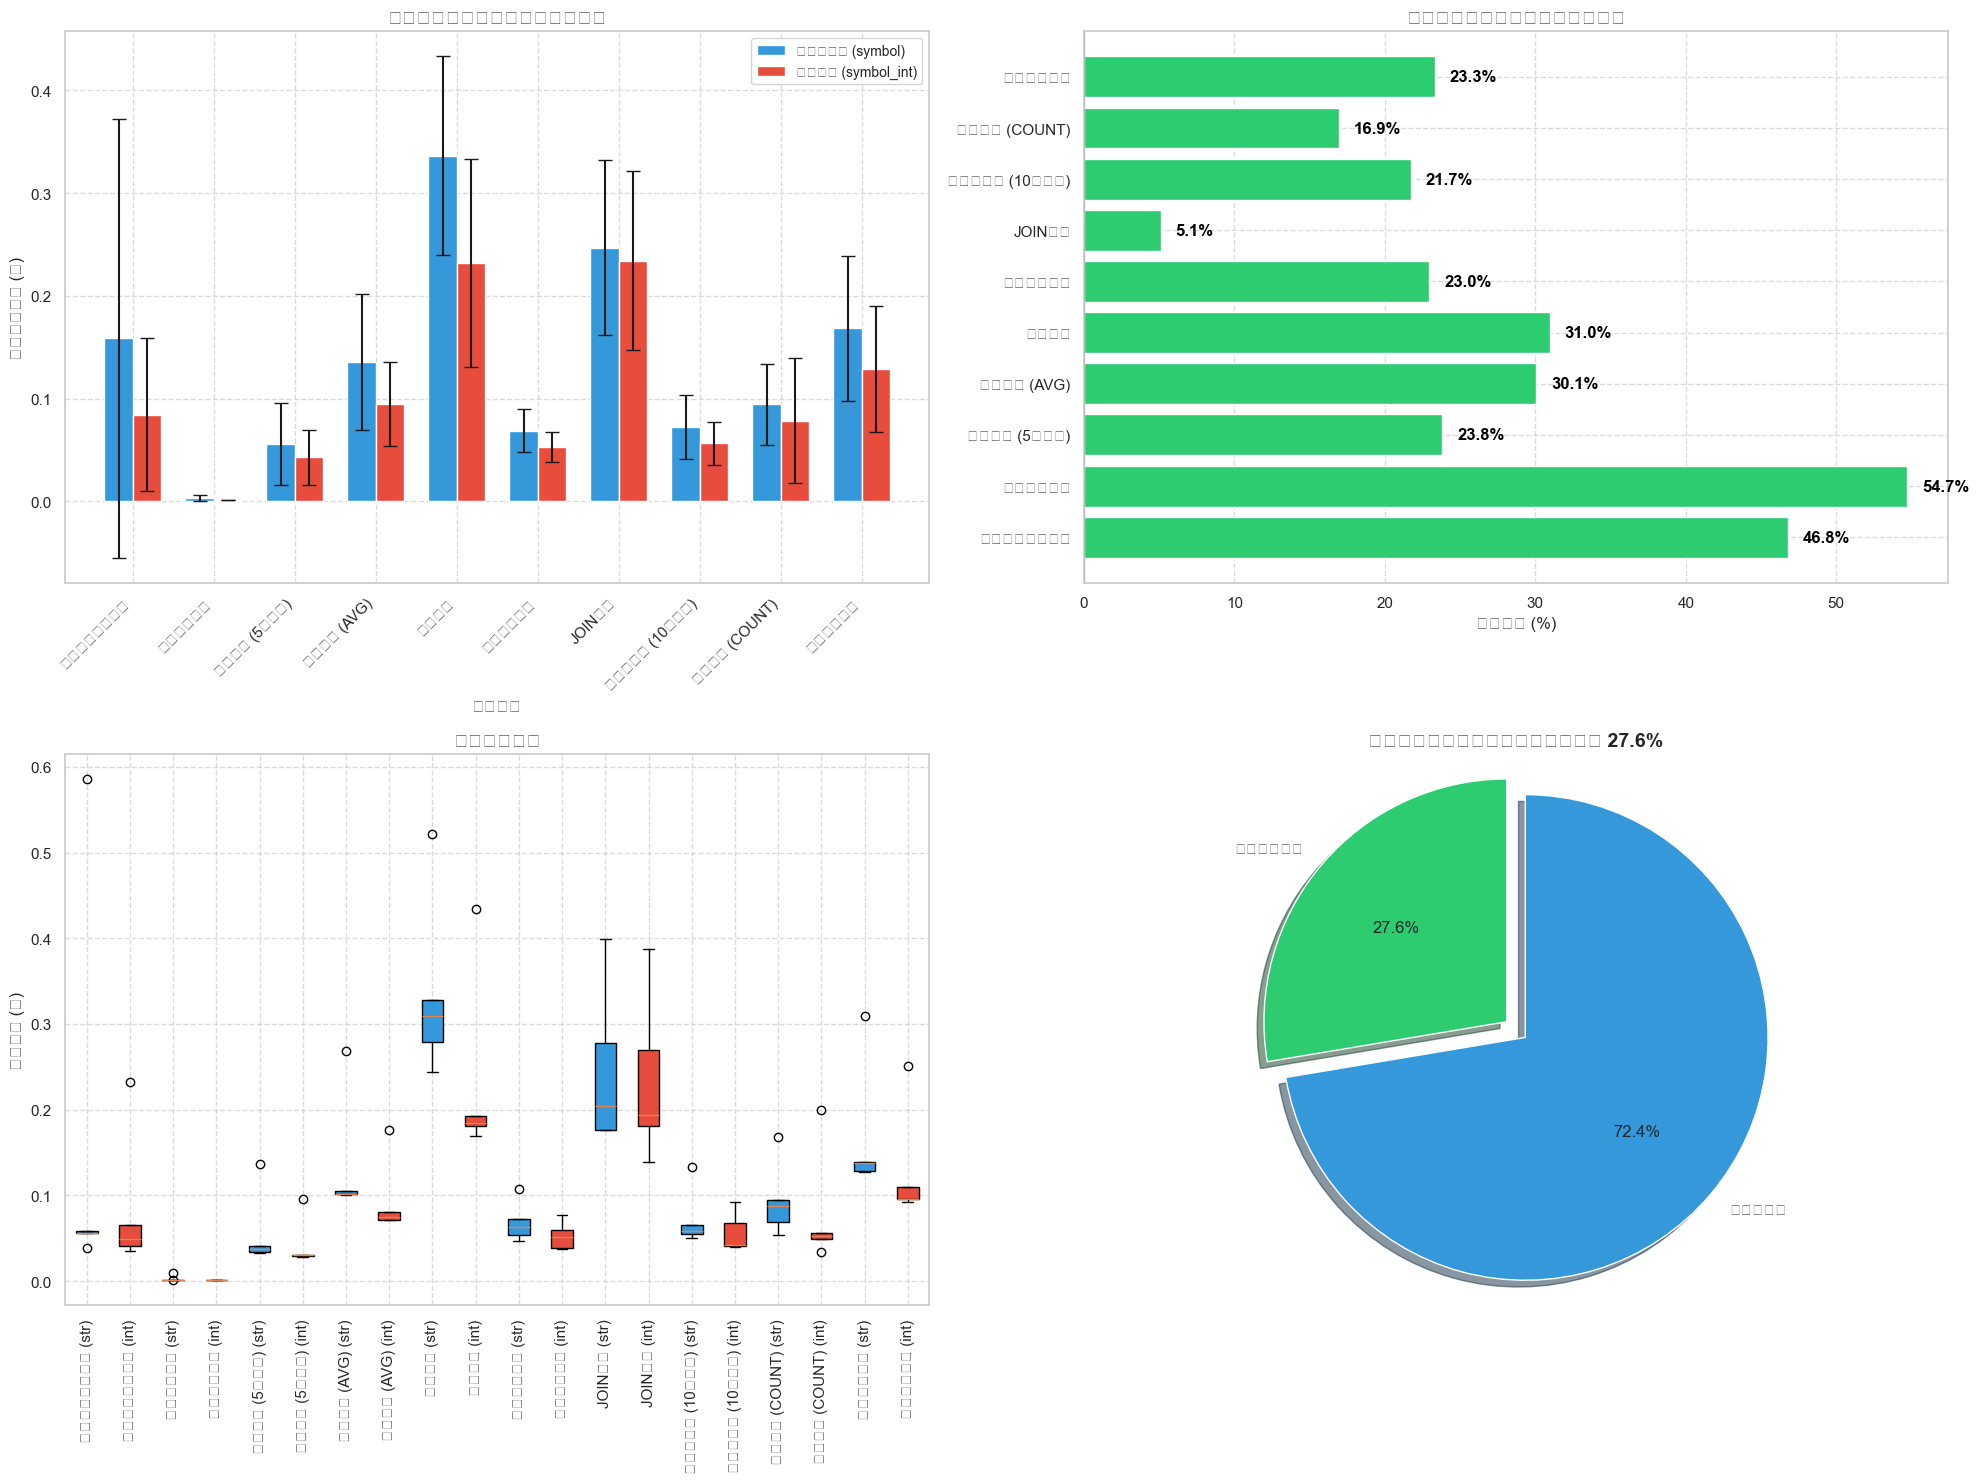

性能测试结果图表已保存为 'query_performance_comparison.png'

===== 性能测试详细报告 =====
测试场景数量: 10
总体平均字符串查询时间: 0.134089 秒
总体平均整数查询时间: 0.100725 秒
总体平均性能提升: 27.64%

各场景详细数据:
         查询类型  字符串查询平均时间(秒)  整数查询平均时间(秒)  字符串查询标准差  整数查询标准差   性能提升(%)  字符串查询最小时间  字符串查询最大时间  整数查询最小时间  整数查询最大时间
     单条记录精确查询      0.158925     0.084579  0.213602 0.074600 46.780362   0.038127   0.585880  0.034979  0.232298
       日期范围查询      0.003030     0.001372  0.002961 0.000305 54.702402   0.001007   0.008923  0.001009  0.001763
  批量查询 (5个股票)      0.056202     0.042812  0.040074 0.026401 23.825600   0.032534   0.136129  0.028174  0.095587
   聚合查询 (AVG)      0.135674     0.094880  0.066305 0.040682 30.067807   0.100386   0.268240  0.070882  0.175946
         排序查询      0.336186     0.232131  0.096809 0.101034 30.951627   0.244445   0.521399  0.169337  0.433662
       复杂条件查询      0.068799     0.053008  0.021024 0.014528 22.952973   0.047327   0.107191  0.037772  0.077337
       JOIN查询      0.246829     0.234233  0.084898 0.087325  

In [ ]:
# 查询性能可视化
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from matplotlib import font_manager
font_path = '/Volumes/share/data/WBQ/note/4_性能测试/SimHei.ttf'  # 替换为SimHei.ttf的实际路径
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'SimHei'

def visualize_performance_results(results):
    """将性能测试结果可视化为图表"""
    if not results:
        print("没有测试结果可供可视化")
        return
    
    # 设置图表风格
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 15))
    
    # 1. 查询时间对比 - 条形图
    plt.subplot(2, 2, 1)
    test_names = [r['name'] for r in results]
    str_times = [r['avg_str_time'] for r in results]
    int_times = [r['avg_int_time'] for r in results]
    
    x = np.arange(len(test_names))
    width = 0.35
    
    plt.bar(x - width/2, str_times, width, label='字符串查询 (symbol)', color='#3498db', 
            yerr=[r['std_str_time'] for r in results], capsize=5)
    plt.bar(x + width/2, int_times, width, label='整数查询 (symbol_int)', color='#e74c3c', 
            yerr=[r['std_int_time'] for r in results], capsize=5)
    
    plt.xlabel('查询类型', fontsize=12)
    plt.ylabel('平均查询时间 (秒)', fontsize=12)
    plt.title('不同查询类型的平执行时间对比', fontsize=14, fontweight='bold')
    plt.xticks(x, [name if len(name) < 15 else name[:12] + '...' for name in test_names], rotation=45, ha='right')
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 2. 性能提升百分比 - 水平条形图
    plt.subplot(2, 2, 2)
    improvements = [r['improvement'] for r in results]
    colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvements]
    
    y_pos = np.arange(len(test_names))
    plt.barh(y_pos, improvements, color=colors)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
    plt.yticks(y_pos, [name if len(name) < 15 else name[:12] + '...' for name in test_names])
    plt.xlabel('性能提升 (%)', fontsize=12)
    plt.title('整数编码相对于字符串的性能提升', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 添加数值标签
    for i, v in enumerate(improvements):
        plt.text(v + (1 if v >= 0 else -1), i, f"{v:.1f}%", 
                 va='center', fontweight='bold', color='black')
    
    # 3. 查询时间分布 - 箱线图
    plt.subplot(2, 2, 3)
    
    # 准备数据
    data_to_plot = []
    labels = []
    
    for r in results:
        data_to_plot.append(r['str_times'])
        data_to_plot.append(r['int_times'])
        labels.append(f"{r['name']} (str)")
        labels.append(f"{r['name']} (int)")
    
    # 绘制箱线图
    box = plt.boxplot(data_to_plot, patch_artist=True, labels=labels)
    
    # 设置颜色
    colors = []
    for i in range(len(data_to_plot)):
        if i % 2 == 0:  # 字符串查询
            colors.append('#3498db')
        else:  # 整数查询
            colors.append('#e74c3c')
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.xticks(rotation=90)
    plt.ylabel('查询时间 (秒)', fontsize=12)
    plt.title('查询时间分布', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 4. 平均性能对比 - 饼图
    plt.subplot(2, 2, 4)
    
    # 计算平均性能提升
    avg_improvement = sum(improvements) / len(improvements)
    
    # 创建饼图数据
    if avg_improvement > 0:
        # 整数查询更快
        labels = ['整数查询更快', '字符串查询']
        sizes = [avg_improvement, 100 - avg_improvement]
        colors = ['#2ecc71', '#3498db']
        title = f'平均而言，整数查询比字符串查询快 {avg_improvement:.1f}%'
    else:
        # 字符串查询更快
        labels = ['字符串查询更快', '整数查询']
        sizes = [-avg_improvement, 100 + avg_improvement]
        colors = ['#3498db', '#e74c3c']
        title = f'平均而言，字符串查询比整数查询快 {-avg_improvement:.1f}%'
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
            startangle=90, explode=(0.1, 0), shadow=True)
    plt.axis('equal')
    plt.title(title, fontsize=14, fontweight='bold')
    
    # 调整布局并保存
    plt.tight_layout()
    plt.savefig('query_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("性能测试结果图表已保存为 'query_performance_comparison.png'")
    
    # 创建详细的性能报告
    create_performance_report(results)

def create_performance_report(results):
    """创建详细的性能测试报告"""
    # 创建DataFrame
    report_data = []
    
    for r in results:
        report_data.append({
            '查询类型': r['name'],
            '字符串查询平均时间(秒)': r['avg_str_time'],
            '整数查询平均时间(秒)': r['avg_int_time'],
            '字符串查询标准差': r['std_str_time'],
            '整数查询标准差': r['std_int_time'],
            '性能提升(%)': r['improvement'],
            '字符串查询最小时间': min(r['str_times']),
            '字符串查询最大时间': max(r['str_times']),
            '整数查询最小时间': min(r['int_times']),
            '整数查询最大时间': max(r['int_times']),
        })
    
    df = pd.DataFrame(report_data)
    
    # 计算总体统计
    avg_str_time = df['字符串查询平均时间(秒)'].mean()
    avg_int_time = df['整数查询平均时间(秒)'].mean()
    avg_improvement = df['性能提升(%)'].mean()
    
    # 打印报告
    print("\n===== 性能测试详细报告 =====")
    print(f"测试场景数量: {len(results)}")
    print(f"总体平均字符串查询时间: {avg_str_time:.6f} 秒")
    print(f"总体平均整数查询时间: {avg_int_time:.6f} 秒")
    print(f"总体平均性能提升: {avg_improvement:.2f}%")
    
    # 打印每个场景的详细信息
    print("\n各场景详细数据:")
    print(df.to_string(index=False))
    
    # 保存报告到CSV
    df.to_csv('performance_test_report.csv', index=False)
    print("\n详细报告已保存到 'performance_test_report.csv'")

def run_performance_test(test_cases, num_iterations=5):
    """
    运行性能测试
    
    Args:
        test_cases: 测试用例列表，每个测试用例是一个字典，包含name, str_query和int_query
        num_iterations: 每个测试用例重复执行的次数
    
    Returns:
        测试结果列表
    """
    results = []
    
    for test_idx, test_case in enumerate(test_cases):
        str_query = test_case['str_query']
        int_query = test_case['int_query']
        test_name = test_case['name']
        
        print(f"\n测试 {test_idx+1}/{len(test_cases)}: {test_name}")
        
        str_times = []
        int_times = []
        
        for i in range(num_iterations):
            try:
                # 清除缓存
                if i == 0:  # 只在第一次迭代时清除缓存
                    try:
                        clickhouse_client.execute("SYSTEM DROP MARK CACHE")
                        clickhouse_client.execute("SYSTEM DROP UNCOMPRESSED CACHE")
                    except:
                        pass  # 忽略清除缓存的错误
                
                # 测试字符串查询
                start_time = time.time()
                clickhouse_client.execute(str_query)
                str_time = time.time() - start_time
                str_times.append(str_time)
                
                # 测试整数查询
                start_time = time.time()
                clickhouse_client.execute(int_query)
                int_time = time.time() - start_time
                int_times.append(int_time)
                
                print(f"  迭代 {i+1}/{num_iterations}: 字符串 {str_time:.6f}秒, 整数 {int_time:.6f}秒")
            except Exception as e:
                print(f"  迭代 {i+1}/{num_iterations} 出错: {str(e)}")
                print(f"  字符串查询: {str_query}")
                print(f"  整数查询: {int_query}")
                continue
        
        if not str_times or not int_times:
            print(f"  测试 {test_name} 失败，跳过")
            continue
        
        # 计算平均时间和标准差
        avg_str_time = sum(str_times) / len(str_times)
        avg_int_time = sum(int_times) / len(int_times)
        std_str_time = (sum((t - avg_str_time) ** 2 for t in str_times) / len(str_times)) ** 0.5
        std_int_time = (sum((t - avg_int_time) ** 2 for t in int_times) / len(int_times)) ** 0.5
        
        improvement = (avg_str_time - avg_int_time) / avg_str_time * 100
        
        print(f"  平均: 字符串 {avg_str_time:.6f}±{std_str_time:.6f}秒, 整数 {avg_int_time:.6f}±{std_int_time:.6f}秒")
        print(f"  性能提升: {improvement:.2f}%")
        
        results.append({
            'name': test_name,
            'str_times': str_times,
            'int_times': int_times,
            'avg_str_time': avg_str_time,
            'avg_int_time': avg_int_time,
            'std_str_time': std_str_time,
            'std_int_time': std_int_time,
            'improvement': improvement
        })
    
    return results

# 定义多种查询场景的测试用例
def create_test_cases():
    """创建多种查询场景的测试用例"""
    # 获取一些随机的股票代码用于测试
    symbols = clickhouse_client.execute("""
    SELECT DISTINCT symbol FROM stock_data 
    ORDER BY rand() 
    LIMIT 20
    """)
    
    symbol_ints = []
    for symbol_tuple in symbols:
        symbol = symbol_tuple[0]
        code, exchange = symbol.split('.')
        if exchange.upper() == 'SH':
            prefix = '1'
        elif exchange.upper() == 'SZ':
            prefix = '2'
        else:
            continue
        symbol_ints.append(int(prefix + code))
    
    # 确保我们有足够的股票代码
    if len(symbols) < 10 or len(symbol_ints) < 10:
        print("警告: 没有足够的股票代码用于测试")
        return []
    
    # 创建测试用例
    test_cases = [
        # 1. 单条记录精确查询
        {
            'name': '单条记录精确查询',
            'str_query': f"SELECT * FROM stock_data WHERE symbol = '{symbols[0][0]}' LIMIT 1000",
            'int_query': f"SELECT * FROM stock_data_with_int WHERE symbol_int = {symbol_ints[0]} LIMIT 1000"
        },
        
        # 2. 日期范围查询
        {
            'name': '日期范围查询',
            'str_query': f"SELECT * FROM stock_data WHERE symbol = '{symbols[1][0]}' AND frame BETWEEN '2020-01-01' AND '2020-12-31'",
            'int_query': f"SELECT * FROM stock_data_with_int WHERE symbol_int = {symbol_ints[1]} AND frame BETWEEN '2020-01-01' AND '2020-12-31'"
        },
        
        # 3. 批量查询 (IN条件)
        {
            'name': '批量查询 (5个股票)',
            'str_query': f"SELECT * FROM stock_data WHERE symbol IN ('{symbols[0][0]}', '{symbols[1][0]}', '{symbols[2][0]}', '{symbols[3][0]}', '{symbols[4][0]}') LIMIT 1000",
            'int_query': f"SELECT * FROM stock_data_with_int WHERE symbol_int IN ({symbol_ints[0]}, {symbol_ints[1]}, {symbol_ints[2]}, {symbol_ints[3]}, {symbol_ints[4]}) LIMIT 1000"
        },
        
        # 4. 聚合查询 (AVG)
        {
            'name': '聚合查询 (AVG)',
            'str_query': f"SELECT AVG(close) FROM stock_data WHERE symbol = '{symbols[2][0]}' GROUP BY toYYYYMM(frame)",
            'int_query': f"SELECT AVG(close) FROM stock_data_with_int WHERE symbol_int = {symbol_ints[2]} GROUP BY toYYYYMM(frame)"
        },
        
        # 5. 排序查询
        {
            'name': '排序查询',
            'str_query': f"SELECT * FROM stock_data WHERE symbol = '{symbols[3][0]}' ORDER BY frame DESC LIMIT 1000",
            'int_query': f"SELECT * FROM stock_data_with_int WHERE symbol_int = {symbol_ints[3]} ORDER BY frame DESC LIMIT 1000"
        },
        
        # 6. 复杂条件查询
        {
            'name': '复杂条件查询',
            'str_query': f"SELECT * FROM stock_data WHERE symbol = '{symbols[4][0]}' AND close > open AND vol > 1000000 LIMIT 1000",
            'int_query': f"SELECT * FROM stock_data_with_int WHERE symbol_int = {symbol_ints[4]} AND close > open AND vol > 1000000 LIMIT 1000"
        },
        
        # 7. JOIN查询
        {
            'name': 'JOIN查询',
            'str_query': f"""
            SELECT a.symbol, a.frame, a.close, b.close as prev_close
            FROM stock_data a
            LEFT JOIN stock_data b ON a.symbol = b.symbol AND b.frame = addDays(a.frame, -1)
            WHERE a.symbol = '{symbols[5][0]}'
            LIMIT 1000
            """,
            'int_query': f"""
            SELECT a.symbol_int, a.frame, a.close, b.close as prev_close
            FROM stock_data_with_int a
            LEFT JOIN stock_data_with_int b ON a.symbol_int = b.symbol_int AND b.frame = addDays(a.frame, -1)
            WHERE a.symbol_int = {symbol_ints[5]}
            LIMIT 1000
            """
        },
        
        # 8. 大批量查询 (更多股票)
        {
            'name': '大批量查询 (10个股票)',
            'str_query': "SELECT * FROM stock_data WHERE symbol IN (" + ", ".join([f"'{s[0]}'" for s in symbols[:10]]) + ") LIMIT 5000",
            'int_query': "SELECT * FROM stock_data_with_int WHERE symbol_int IN (" + ", ".join([str(s) for s in symbol_ints[:10]]) + ") LIMIT 5000"
        },
        
        # 9. 聚合查询 (COUNT)
        {
            'name': '聚合查询 (COUNT)',
            'str_query': f"SELECT COUNT(*) FROM stock_data WHERE symbol = '{symbols[6][0]}' GROUP BY toYear(frame)",
            'int_query': f"SELECT COUNT(*) FROM stock_data_with_int WHERE symbol_int = {symbol_ints[6]} GROUP BY toYear(frame)"
        },
        
        # 10. 复杂聚合查询
        {
            'name': '复杂聚合查询',
            'str_query': f"""
            SELECT 
                toYear(frame) AS year,
                AVG(close) AS avg_close,
                MAX(high) AS max_high,
                MIN(low) AS min_low,
                SUM(vol) AS total_vol
            FROM stock_data 
            WHERE symbol = '{symbols[7][0]}'
            GROUP BY year
            ORDER BY year
            """,
            'int_query': f"""
            SELECT 
                toYear(frame) AS year,
                AVG(close) AS avg_close,
                MAX(high) AS max_high,
                MIN(low) AS min_low,
                SUM(vol) AS total_vol
            FROM stock_data_with_int 
            WHERE symbol_int = {symbol_ints[7]}
            GROUP BY year
            ORDER BY year
            """
        }
    ]
    
    return test_cases


# 创建测试用例
test_cases = create_test_cases()
    
if not test_cases:
    print("无法创建测试用例，请检查数据库连接和表结构")
    exit()
    
# 运行性能测试
print(f"开始运行 {len(test_cases)} 个测试用例，每个用例重复 5 次...")
results = run_performance_test(test_cases, num_iterations=5)
    
if not results:
    print("测试失败，没有结果可供分析")
    exit()
    
# 可视化结果
visualize_performance_results(results)

In [72]:
sql = "SELECT * FROM stock_data WHERE symbol IN ['605382.SH','003741.SZ','600597.SH','001602.SZ'] LIMIT 1000"
%timeit clickhouse_client.execute(sql)

26.7 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
